<h1 align="center"> Practical Class 8 : High Level Current Steering DAC modelling for statistical analysis</h1>

<p align="justify">
In this practical class it is demonstrated how to create an high level model of the ADC / DAC and its sub blocks to significantly speed up the statistical analysis of the converter, before starting its electrical simulation. This step enables to determine the specifications of each of the sub blocks of the converter, and as such it is very important.
</p>

In [100]:
from functools import partial

# mathematical computing
import numpy as np
import scipy as sp
from scipy import signal # to generate the noise signal
import seaborn as sns # to observe the noise signal's histogram

sns.set_theme()
sns.set_palette("colorblind")

from numpy.random import uniform, normal # random numbers fitted into a uniform distribution
# plotting
import matplotlib.pyplot as plt
# import the models and utilities functions
from utils import ideal_dac, ideal_adc, nonideal_adc, dec2bin, bin2dec

%matplotlib inline

In [101]:
# number of simulation points
Np = 1000
# define the time base
Fs = 1e9 # Hz
Ts = 1/Fs # s
tD = np.arange(0,Np)*Ts; # (0:Np-1) == np.arange(0,Np)

<h2 align="left"> Current Steering DAC Modelling - Binary Weighted Currents </h2>


The current-steering DAC is based on a current mirror. It is well known that the current mismatch in a current mirror 

In [102]:
# model the dac 
nbits = 8
vref = 1 # V
vlsb = vref/2**nbits # ideal vlsb

In [103]:
# define the DAC currents of each transistor
uA = 1e-6 # uA 
iu = 10 * uA # unitary current

currs = iu * np.ones(2**nbits-1) # current vector

# model the gate width of the nmos transistors
u_err_curr = 0.0
std_err_curr = 0.01 # 1% of the gate width
curr_mismatch = normal(u_err_curr, std_err_curr, len(currs)) # current mismatch vector
currs = currs * (1 + curr_mismatch) # current vector with mismatch
currs.shape

(255,)

Text(0.5, 1.0, 'Current Mismatch distribution')

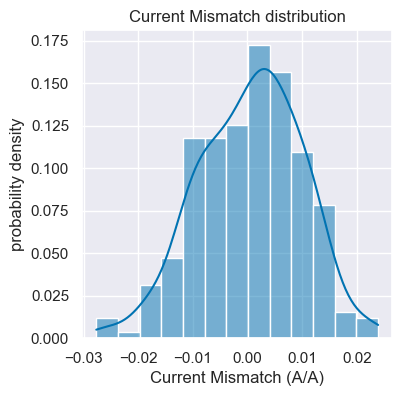

In [104]:
# observe the mismatch distribution
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(curr_mismatch, ax=ax, stat="probability", kde=True)
ax.set_xlabel('Current Mismatch (A/A)')
ax.set_ylabel('probability density')
ax.grid(True)
ax.set_title('Current Mismatch distribution')

In [105]:
# define the binary weighted currents from the current vector of the DAC
i_idxs = {id: np.arange(2**id, 2**(id+1))-1 for id in range(nbits)}
bw_currs = np.array([np.sum([currs[i] for i in i_idxs[id]]) for id in range(nbits)])
bw_currs, i_idxs

(array([1.00696025e-05, 1.99902762e-05, 4.00578118e-05, 8.00500611e-05,
        1.59760969e-04, 3.20412381e-04, 6.40738303e-04, 1.28029701e-03]),
 {0: array([0]),
  1: array([1, 2]),
  2: array([3, 4, 5, 6]),
  3: array([ 7,  8,  9, 10, 11, 12, 13, 14]),
  4: array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
  5: array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
         48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
  6: array([ 63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
          76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
          89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
         102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
         115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]),
  7: array([127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 

In [106]:
def get_iout(incode, bw_currs, invert_code=True):
    """Compute the output current of the DAC given the input code and the binary weighted currents
    It is assumed that:
        - the input code is a binary number with nbits from MSB to LSB
        - the binary weighted currents are ordered from LSB to MSB
    Parameters:
        incode (int): input code
        bw_currs (np.array): binary weighted currents
    """
    icode = incode[:: -1 if invert_code else 1] # invert the code if needed
    return icode.reshape((1,-1)) @ bw_currs.reshape((-1,1))

In [107]:
# define the input codes 
codes = np.arange(2**nbits)
incodes_bin = np.array([dec2bin(code, nbits) for code in codes])
# vectorize the iout function
iof = partial(get_iout, bw_currs=bw_currs)
iofv = np.vectorize(iof, signature='(k)->(m)')
iout = iofv(incodes_bin).flatten()


Text(0.5, 1.0, 'DAC Transfer Function')

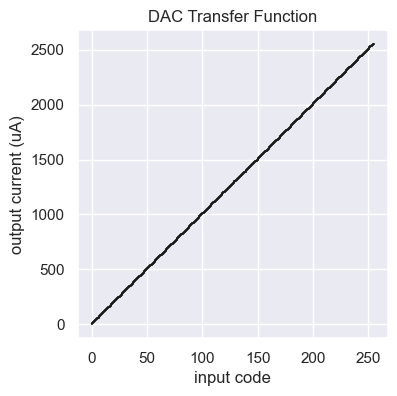

In [108]:
# plot the transfer function of the DAC
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.step(codes, iout/uA, 'k', label='output voltage')
ax.set_xlabel('input code')
ax.set_ylabel('output current (uA)')
ax.grid(True)
ax.set_title('DAC Transfer Function')

In [109]:
# compute the inl and dnl
ilsb_measured = (iout[2**nbits - 1] - iout[0])/(2**nbits - 1)
dnl = np.diff(iout)/ilsb_measured - 1
inl = np.array([0] + np.cumsum(dnl).tolist())
assert len(dnl) == 2**nbits - 1, 'DNL length is not correct: {}'.format(len(dnl))
assert len(inl) == 2**nbits
# compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
# difference between the minimum and maximum value of the INL)
dac_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
dac_linearity

10.757484813740668

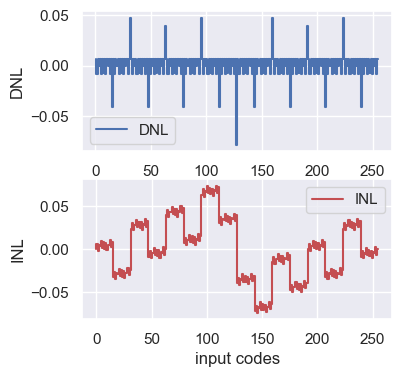

In [110]:
# plot the DNL and INL
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].step(codes[1:], dnl, 'b', label='DNL')
ax[0].set_xlabel('input codes')
ax[0].set_ylabel('DNL')
ax[0].legend()
ax[0].grid(True)
ax[1].step(codes, inl, 'r', label='INL')
ax[1].set_xlabel('input codes')
ax[1].set_ylabel('INL')
ax[1].legend()
ax[1].grid(True)

In [111]:
# run a monte carlo simulation and observe the 
# dac linearity against the randomized current mismatch
num_circuits = 100


uA = 1e-6 # uA 
iu = 10 * uA # unitary current

#define the input codes
codes = np.arange(2**nbits)
incodes_bin = np.array([dec2bin(code, nbits) for code in codes])

dac_res = []

for circ in range(num_circuits):
    # define the DAC currents of each transistor
    currs = iu * np.ones(2**nbits-1) # current vector

    # model the gate width of the nmos transistors
    u_err_curr = 0.0
    std_err_curr = 0.01 # 1% of the gate width
    curr_mismatch = normal(u_err_curr, std_err_curr, len(currs)) # current mismatch vector
    currs = currs * (1 + curr_mismatch) # current vector with mismatch
    # define the binary weighted currents from the current vector of the DAC
    i_idxs = {id: np.arange(2**id, 2**(id+1))-1 for id in range(nbits)}
    bw_currs = np.array([np.sum([currs[i] for i in i_idxs[id]]) for id in range(nbits)])
    # vectorize the iout computation function
    iof = partial(get_iout, bw_currs=bw_currs)
    iofv = np.vectorize(iof, signature='(k)->(m)')
    iout = iofv(incodes_bin).flatten()
    # compute the inl and dnl
    ilsb_measured = (iout[2**nbits - 1] - iout[0])/(2**nbits - 1)
    dnl = np.diff(iout)/ilsb_measured - 1
    inl = np.array([0] + np.cumsum(dnl).tolist())
    # compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
    # difference between the minimum and maximum value of the INL)
    dac_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
    dac_res.append(dac_linearity)

dac_res = np.array(dac_res)

Text(0.5, 1.0, 'Binary Weighted Current Steering DAC resolution distribution against current mismatch')

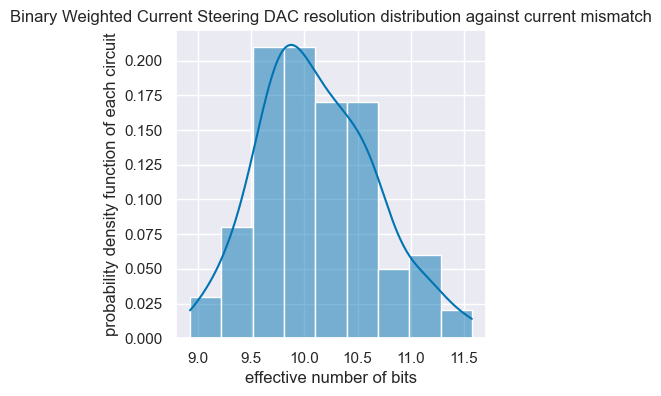

In [112]:
# plot the histogram of the dac linearity
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(dac_res, ax=ax, stat="probability", kde=True)
ax.set_xlabel('effective number of bits')
ax.set_ylabel('probability density function of each circuit')
ax.grid(True)
ax.set_title('Binary Weighted Current Steering DAC resolution distribution against current mismatch')

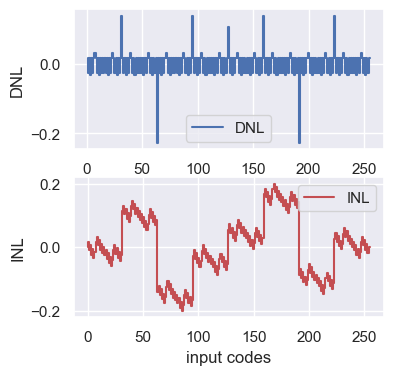

In [113]:
# plot the DNL and INL
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].step(codes[1:], dnl, 'b', label='DNL')
ax[0].set_xlabel('input codes')
ax[0].set_ylabel('DNL')
ax[0].legend()
ax[0].grid(True)
ax[1].step(codes, inl, 'r', label='INL')
ax[1].set_xlabel('input codes')
ax[1].set_ylabel('INL')
ax[1].legend()
ax[1].grid(True)

<h2 align="left"> Current Steering DAC Modelling - Unitary Currents </h2>

<p align="justify">
The use of unitary currents reduces the nefast effect of current mismatch on the linearity of the DAC, as it is going to be observed at the end of this section. The fact that only a signle switch and a single current is added to the output in the transition between each successive code severely reduces the effect of current mismatch, improving the DNL of the DAC.
But this increased mismatch robustness comes at a cost of increased in-silicon area (which also increases the cost of fabrication of the IC) and circuit complexity, once it is necessary to design the digital decoder to activate the 2**N - 1 switches to control each unitary current. 
</p>

In [114]:
# define the DAC currents of each transistor
uA = 1e-6 # uA 
iu = 10 * uA # unitary current

currs = iu * np.ones(2**nbits-1) # current vector

# model the gate width of the nmos transistors
u_err_curr = 0.0
std_err_curr = 0.01 # 1% of the gate width
curr_mismatch = normal(u_err_curr, std_err_curr, len(currs)) # current mismatch vector
currs = currs * (1 + curr_mismatch) # current vector with mismatch
currs.shape

(255,)

In [115]:
def decoder(incode):
    """ Implements a digital decoder to retreive 2^N
    Parameters:
        incode: binary word going from MSB to LSB
    Returns:
        outcode: output code
    """
    # create the output container
    outcode = np.zeros(2**len(incode)-1)
    dec = bin2dec(incode, len(incode))
    outcode[:dec] = 1
    return outcode

def get_iout_unitary(incode, unit_currs=None):
    """ Computes the output current of a unitary current steering DAC
    Parameters:
        incode: binary word going from MSB to LSB
        unit_currs: unitary current vector of the DAC
    Returns:
        outcode: output code
    """
    return decoder(incode).reshape((1,-1)) @ unit_currs.reshape((-1, 1))

In [116]:
# compute the iout for any given input code
codes = np.arange(2**nbits)
incodes_bin = dec2bin(codes, nbits)

# vectorize the function
iof = partial(get_iout_unitary, unit_currs=currs)
iofv = np.vectorize(iof, signature="(k)->(m)")
iout = iofv(incodes_bin).flatten()

Text(0.5, 1.0, 'DAC Transfer Function')

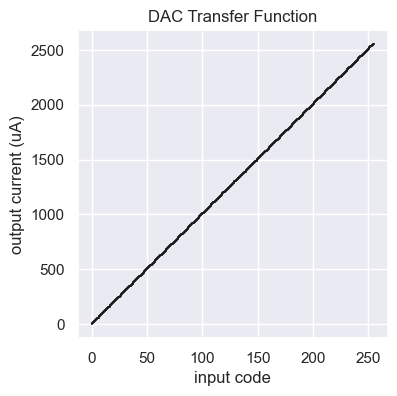

In [117]:
# plot the transfer function of the DAC
# plot the transfer function of the DAC
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.step(codes, iout/uA, 'k', label='output voltage')
ax.set_xlabel('input code')
ax.set_ylabel('output current (uA)')
ax.grid(True)
ax.set_title('DAC Transfer Function')

In [118]:
# compute the inl and dnl
ilsb_measured = (iout[2**nbits - 1] - iout[0])/(2**nbits - 1)
dnl = np.diff(iout)/ilsb_measured - 1
inl = np.array([0] + np.cumsum(dnl).tolist())
assert len(dnl) == 2**nbits - 1, 'DNL length is not correct: {}'.format(len(dnl))
assert len(inl) == 2**nbits
# compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
# difference between the minimum and maximum value of the INL)
dac_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
dac_linearity

10.544691620334387

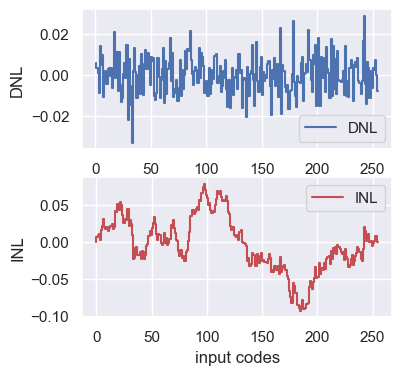

In [119]:
# plot the DNL and INL
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].step(codes[1:], dnl, 'b', label='DNL')
ax[0].set_xlabel('input codes')
ax[0].set_ylabel('DNL')
ax[0].legend()
ax[0].grid(True)
ax[1].step(codes, inl, 'r', label='INL')
ax[1].set_xlabel('input codes')
ax[1].set_ylabel('INL')
ax[1].legend()
ax[1].grid(True)

In [120]:
# run a monte carlo simulation and observe the 
# dac linearity against the randomized current mismatch
num_circuits = 100


uA = 1e-6 # uA 
iu = 10 * uA # unitary current

#define the input codes
codes = np.arange(2**nbits)
incodes_bin = np.array([dec2bin(code, nbits) for code in codes])

dac_res = []

for circ in range(num_circuits):
    # define the DAC currents of each transistor
    currs = iu * np.ones(2**nbits-1) # current vector

    # model the gate width of the nmos transistors
    u_err_curr = 0.0
    std_err_curr = 0.01 # 1% of the gate width
    curr_mismatch = normal(u_err_curr, std_err_curr, len(currs)) # current mismatch vector
    currs = currs * (1 + curr_mismatch) # current vector with mismatch
    # define the binary weighted currents from the current vector of the DAC
    # vectorize the iout computation function
    iof = partial(get_iout_unitary, unit_currs=currs)
    iofv = np.vectorize(iof, signature="(k)->(m)")
    iout = iofv(incodes_bin).flatten()
    # compute the inl and dnl
    ilsb_measured = (iout[2**nbits - 1] - iout[0])/(2**nbits - 1)
    dnl = np.diff(iout)/ilsb_measured - 1
    inl = np.array([0] + np.cumsum(dnl).tolist())
    # compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
    # difference between the minimum and maximum value of the INL)
    dac_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
    dac_res.append(dac_linearity)

dac_res = np.array(dac_res)

Text(0.5, 1.0, 'Unitary Current Steering DAC resolution distribution against current mismatch')

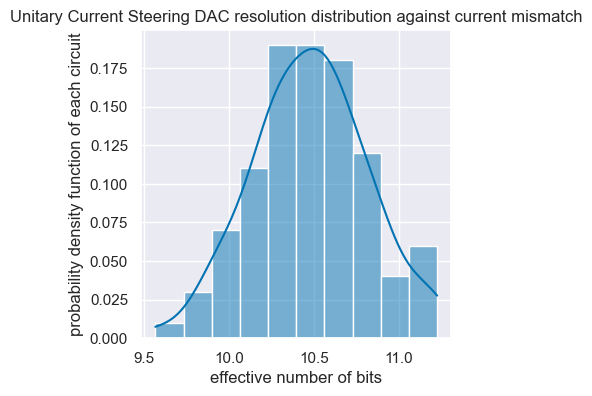

In [121]:
# plot the histogram of the dac linearity
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(dac_res, ax=ax, stat="probability", kde=True)
ax.set_xlabel('effective number of bits')
ax.set_ylabel('probability density function of each circuit')
ax.grid(True)
ax.set_title('Unitary Current Steering DAC resolution distribution against current mismatch')

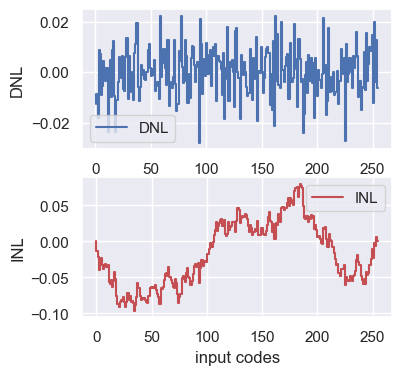

In [122]:
# plot the DNL and INL
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].step(codes[1:], dnl, 'b', label='DNL')
ax[0].set_xlabel('input codes')
ax[0].set_ylabel('DNL')
ax[0].legend()
ax[0].grid(True)
ax[1].step(codes, inl, 'r', label='INL')
ax[1].set_xlabel('input codes')
ax[1].set_ylabel('INL')
ax[1].legend()
ax[1].grid(True)